# Zooplankton vs Copepod obsGLMM

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

### All of the 63 years of the model simulation, but only selct the last 20 (SPECTRA_105-124)

In [4]:
### All 63 years of the 2nd cycle (but I will only select the last 20 years for this analysis)
newNCDFfiles1 = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/SPECTRA_[1]*.nc', recursive=True),
                      key=numericalSort)

ds = xr.open_mfdataset(newNCDFfiles1[5:25],combine='by_coords')

### Select the reggridded files from the 62 yr run, but only select the last 20 years! (regrid_SPECTRA_*_105-124)

In [5]:
zoo3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo3C.[1]*', recursive=True))
zoo3_ds = xr.open_mfdataset(zoo3_inds[5:25],combine='by_coords')
zoo4_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo4C.[1]*', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds[5:25],combine='by_coords')
zoo5_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo5C.[1]*', recursive=True))
zoo5_ds = xr.open_mfdataset(zoo5_inds[5:25],combine='by_coords')
zoo6_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo6C.[1]*', recursive=True))
zoo6_ds = xr.open_mfdataset(zoo6_inds[5:25],combine='by_coords')

In [6]:
zoo3_ds.zoo3C

<xarray.DataArray 'zoo3C' (time: 240, z_t_150m: 15, lat: 180, lon: 360)>
dask.array<concatenate, shape=(240, 15, 180, 360), dtype=float32, chunksize=(12, 15, 180, 360)>
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * time      (time) object 0105-02-01 00:00:00 ... 0125-01-01 00:00:00
Attributes:
    long_name:     Mesozooplankton 1 Carbon
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [7]:
mesozooC_regrid = zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
mesozooC_regrid = mesozooC_regrid.mean(dim='z_t_150m')*150 * 12.011 #mg C/m^3 is this how I convert it to mgC/m^3

In [8]:
mesozooC_regrid.shape

(240, 180, 360)

## Zooplankton Observations. 

In [9]:
cope_files = sorted(glob.glob('/glade/scratch/gabyn/copepod_obsGLMM/*'))
dzt = xr.open_mfdataset(cope_files, combine='by_coords') # Dimensions (month: 12, x: 360, y: 180); Units: mgC m-2

In [10]:
meso_obs = dzt.zmeso200 # Concentration of Mesozooplankton integrated over top 200m (mgC m-3)

In [11]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Mesozooplankton biomass in MARBL-SPECTRA, Heneghan et al. 2020 and difference

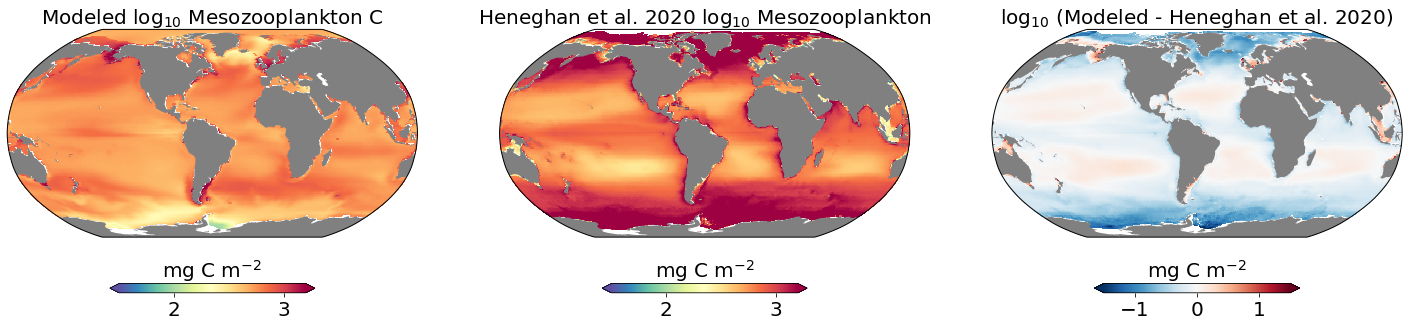

In [12]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = zoo3_ds.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.log10(np.nanmean(meso_obs,axis=0)), coord=dzt.Lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('Heneghan et al. 2020 $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
#fig.text(0.06, 0.975, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.log10(np.nanmean(mesozooC_regrid,axis=0)), coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton C',fontsize =20);
#fig.text(0.385, 0.975, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.log10(np.nanmean(mesozooC_regrid,axis=0))-np.log10(np.nanmean(meso_obs,axis=0)), coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1.5,vmax=1.5)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('log$_{10}$ (Modeled - Heneghan et al. 2020)',fontsize =20);
#fig.text(0.75, 0.975, 'c',fontsize=22, fontweight='bold')

## Create the biomes! 

In [13]:
region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

biome_mask_x1 = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124_remap.nc') # this is on the pop grid 

In [14]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [15]:
mesozooC_regrid_ds_inter = np.empty([20,12,180,360])
mesozooC_regrid_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(20):
    mesozooC_regrid_ds_inter[i,:,:,:] = mesozooC_regrid[x[i]:x[i]+12,:,:] #mgC m-2

In [16]:
nbiome = len(biome_mask_x1.region.values)
nt = len(dzt.month.values)

In [17]:
mesozooC_20yr = np.nanmean(mesozooC_regrid_ds_inter,axis=0) # this is already in mgC m-2

In [18]:
index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,2))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask_x1.REGION_MASK_3D.isel(time=0, region=r).values == 1)

    for t in range(nt):
        # this uses the grid for biomes that is the same as the observed grid. 
        tmp_obs = np.log10(meso_obs[t,:,:].values[region]) 
        biome_means[t,i,0] = np.nanmean(tmp_obs)
        # log10 of the zooplankton C in each region of the biome. 
        tmp_spec = np.log10(mesozooC_20yr[t,:,:][region]) #mg C/m^2
        biome_means[t,i,1] = np.nanmean(tmp_spec)

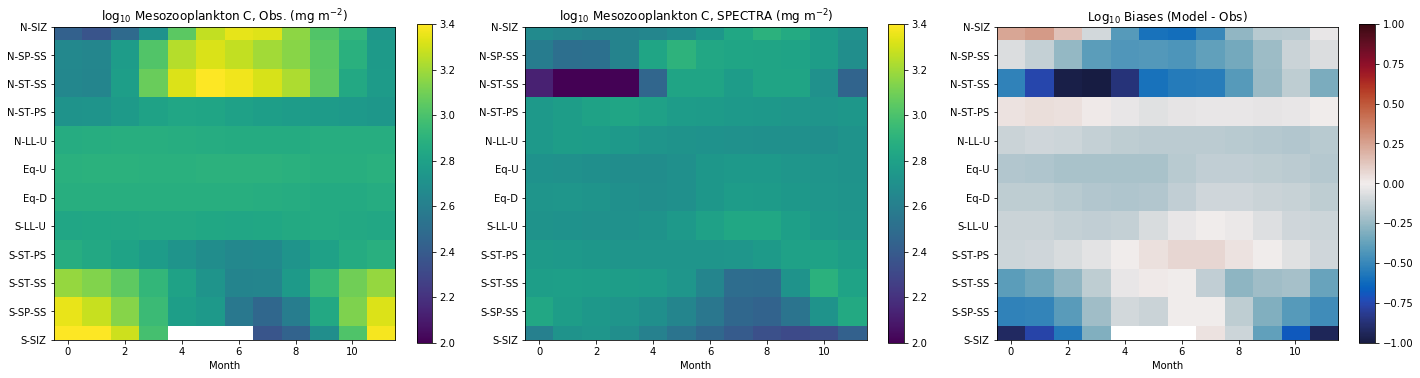

In [19]:
Models = ['Obs.', 'SPECTRA']

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(20,5))

for i in range(2):    
    f = plt.subplot(gs[0,i])
    plt.imshow(biome_means[:,:,i].T, vmax=3.4,vmin=2)
    plt.yticks(range(nbiome), region_NtoS_names)
    plt.xlabel('Month')
    plt.colorbar()
    plt.title('$log_{10}$ Mesozooplankton C, ' +Models[i] + ' (mg $m^{-2}$)')

# bias plot
f = plt.subplot(gs[0,2])
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, cmap=cmocean.cm.balance, vmax=1,vmin=-1)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xlabel('Month')
plt.title('$Log_{10}$ Biases (Model - Obs)')
plt.colorbar()


plt.tight_layout()

## Create the full figure!! 

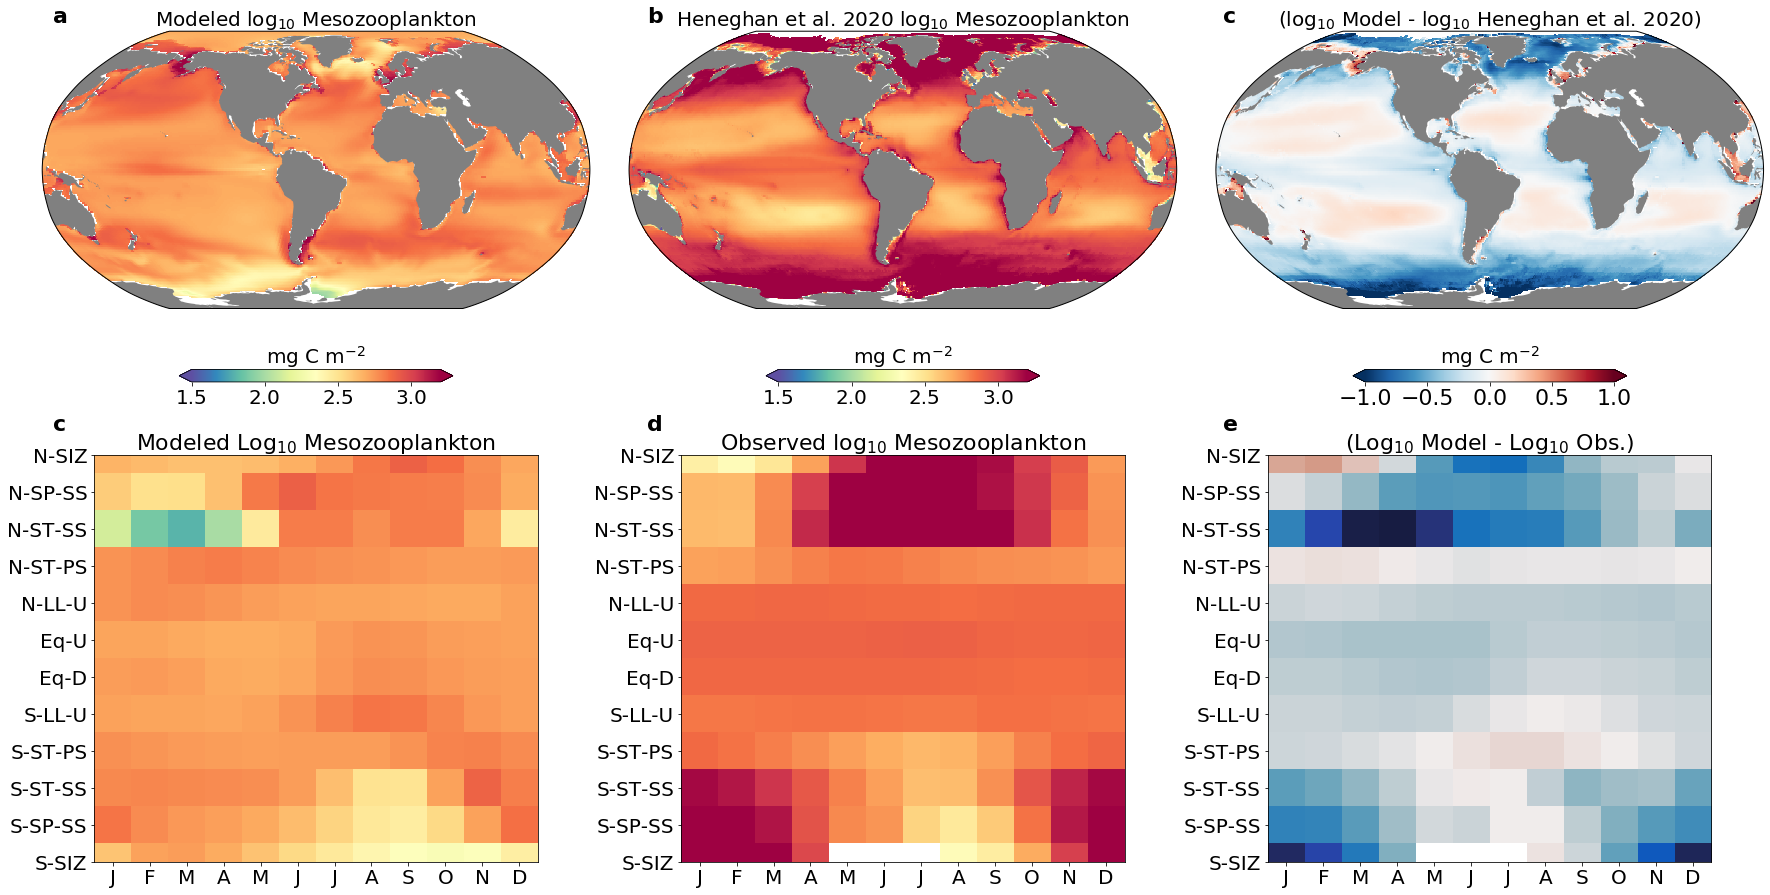

In [21]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = zoo3_ds.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.log10(np.nanmean(meso_obs,axis=0)), coord=dzt.Lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('Heneghan et al. 2020 $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.04, 0.973, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.log10(np.nanmean(mesozooC_regrid,axis=0)), coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton',fontsize =20);
fig.text(0.37, 0.973, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(np.log10(np.nanmean(mesozooC_regrid,axis=0))-np.log10(np.nanmean(meso_obs,axis=0)), coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('(log$_{10}$ Model - log$_{10}$ Heneghan et al. 2020)',fontsize =20);
fig.text(0.69, 0.973, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmin = 1.5, vmax=3.2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $log_{10}$ Mesozooplankton', fontsize=22)
fig.text(0.04, 0.52, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmin = 1.5, vmax=3.2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Mesozooplankton',fontsize=22)
fig.text(0.37, 0.52, 'd',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
a = plt.imshow(biome_diffs.T, vmax=1, vmin=-1, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)',fontsize=22)
fig.text(0.69, 0.52, 'e',fontsize=22, fontweight='bold')
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
cbar.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/mesozoo_SPECTRA_obsGLMM.png',dpi=600, bbox_inches='tight')

## Create the same thing, but with pannels only for the summer months for both, and see if this would improve it at all

In [ ]:
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(mesozooC_20yr[5:8,90:180,:],axis=0)
S_hem = np.nanmean(mesozooC_20yr[[0,1,-1],0:90,:],axis=0)
mesozooC_20yr_summer = np.log10(np.concatenate((S_hem, N_hem), axis=0))

In [ ]:
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(meso_obs[5:8,90:180,:],axis=0)
S_hem = np.nanmean(meso_obs[[0,1,-1],0:90,:],axis=0)
meso_obs_summer = np.log10(np.concatenate((S_hem, N_hem), axis=0))

In [ ]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = zoo3_ds.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(meso_obs_summer, coord=dzt.Lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('Heneghan et al. 2020 $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
#fig.text(0.06, 0.975, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(mesozooC_20yr_summer, coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton C',fontsize =20);
#fig.text(0.385, 0.975, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(mesozooC_20yr_summer-meso_obs_summer, coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('(log$_{10}$ Model - log$_{10}$ Heneghan et al. 2020)',fontsize =20);
#fig.text(0.75, 0.975, 'c',fontsize=22, fontweight='bold')

In [ ]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = zoo3_ds.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(meso_obs_summer, coord=dzt.Lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('Heneghan et al. 2020 $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.04, 0.973, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(mesozooC_20yr_summer, coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton C',fontsize =20);
fig.text(0.37, 0.973, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(mesozooC_20yr_summer-meso_obs_summer, coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('(log$_{10}$ Model - log$_{10}$ Heneghan et al. 2020)',fontsize =20);
fig.text(0.69, 0.973, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmin = 1.5, vmax=3.2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $log_{10}$ Mesozooplankton', fontsize=22)
fig.text(0.04, 0.52, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmin = 1.5, vmax=3.2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Mesozooplankton',fontsize=22)
fig.text(0.37, 0.52, 'd',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
a = plt.imshow(biome_diffs.T, vmax=1, vmin=-1, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)',fontsize=22)
fig.text(0.69, 0.52, 'e',fontsize=22, fontweight='bold')
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/mesozoo_SPECTRA_obsGLMM_summer.png',dpi=600, bbox_inches='tight')

In [ ]:
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(meso_obs[5:8,0:90,:],axis=0)
S_hem = np.nanmean(meso_obs[[0,1,-1],90:180,:],axis=0)
meso_obs_winter = np.log10(np.concatenate((N_hem, S_hem), axis=0))

In [ ]:
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(mesozooC_20yr[5:8,0:90,:],axis=0)
S_hem = np.nanmean(mesozooC_20yr[[0,1,-1],90:180,:],axis=0)
mesozooC_20yr_winter = np.log10(np.concatenate((N_hem, S_hem), axis=0))

In [ ]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = zoo3_ds.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(meso_obs_winter, coord=dzt.Lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('Heneghan et al. 2020 $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.04, 0.973, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(mesozooC_20yr_winter, coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton C',fontsize =20);
fig.text(0.37, 0.973, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(mesozooC_20yr_winter-meso_obs_winter, coord=zoo3_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, zoo, cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
cbar.ax.set_title('mg C $m^{-2}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
ax.set_title('(log$_{10}$ Model - log$_{10}$ Heneghan et al. 2020)',fontsize =20);
fig.text(0.69, 0.973, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmin = 1.5, vmax=3.2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $log_{10}$ Mesozooplankton', fontsize=22)
fig.text(0.04, 0.52, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmin = 1.5, vmax=3.2,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Mesozooplankton',fontsize=22)
fig.text(0.37, 0.52, 'd',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
a = plt.imshow(biome_diffs.T, vmax=1, vmin=-1, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)',fontsize=22)
fig.text(0.69, 0.52, 'e',fontsize=22, fontweight='bold')
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/mesozoo_SPECTRA_obsGLMM_winter.png',dpi=600, bbox_inches='tight')